Installing dependencies on Colab

In [ ]:
!git clone https://github.com/mdefrance/signature-detection.git
!pip install poetry
%cd signature-detection
!poetry config virtualenvs.create false
!poetry install
%cd src

In [ ]:
from google.colab import output

output.enable_custom_widget_manager()

Logging into HF hub

In [ ]:
import os

from dotenv import load_dotenv
from huggingface_hub import login

# Load environment variables from .env file
load_dotenv()

# Access the Hugging Face Hub API token
huggingfacehub_api_token = os.getenv('HUGGINGFACEHUB_API_TOKEN')

# Log in to the Hugging Face Hub
login(token=huggingfacehub_api_token)

Loading tech4humans signature dataset

In [1]:
from datasets import load_dataset

# Load the tech4humans signature dataset
dataset = load_dataset("samuellimabraz/signature-detection")

# Print the dataset to verify it has been loaded correctly
print(dataset["train"][0])

{'image_id': 1825, 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x154CA491580>, 'width': 640, 'height': 640, 'objects': {'id': [2134, 2135, 2136, 2137], 'area': [5081, 1064, 4626, 1503], 'bbox': [[198.0, 55.0, 43.060001373291016, 118.0], [263.0, 195.0, 24.750999450683594, 43.0], [518.0, 37.0, 46.72800064086914, 99.0], [587.0, 157.0, 28.908000946044922, 52.0]], 'category': [0, 0, 0, 0]}}


Converting it to CocoDataset

In [2]:
from utils.dataset import convert_to_coco

output_dir = "datasets"

convert_to_coco(dataset["train"], output_dir, "train", save_images=True)
convert_to_coco(dataset["validation"], output_dir, "val", save_images=True)
convert_to_coco(dataset["test"], output_dir, "test", save_images=True)


Processing test: 100%|██████████| 419/419 [00:01<00:00, 249.20it/s]


Loading pre-trained model

In [5]:
from utils.config import TARGET
from transformers import YolosImageProcessor, YolosForObjectDetection

CKPT_PATH = "hustvl/yolos-base"
IMG_SIZE = 640
ID2LABEL = {0: TARGET}
LABEL2ID = {TARGET: 0}

image_processor = YolosImageProcessor.from_pretrained(CKPT_PATH, do_resize=True, size={"width": IMG_SIZE, "height": IMG_SIZE})
model = YolosForObjectDetection.from_pretrained(CKPT_PATH, num_labels=len(ID2LABEL), id2label=ID2LABEL, label2id=LABEL2ID, ignore_mismatched_sizes=True, device_map="cpu")

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-base and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Converting data into COCO format

In [6]:
from utils.dataset import SignatureDataset

train_dataset = SignatureDataset(img_folder='datasets/images/train', ann_file="datasets/train.json", image_processor=image_processor)
val_dataset = SignatureDataset(img_folder='datasets/images/val', ann_file="datasets/val.json", image_processor=image_processor)
test_dataset = SignatureDataset(img_folder='datasets/images/test', ann_file="datasets/test.json", image_processor=image_processor)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [7]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    """Custom collate function to handle batches of data."""
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]

    return {
        "pixel_values": encoding["pixel_values"],
        "labels": labels,
    }

BATCH_SIZE = 1

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=BATCH_SIZE)
batch = next(iter(train_dataloader))
batch["pixel_values"].shape

torch.Size([1, 3, 640, 640])

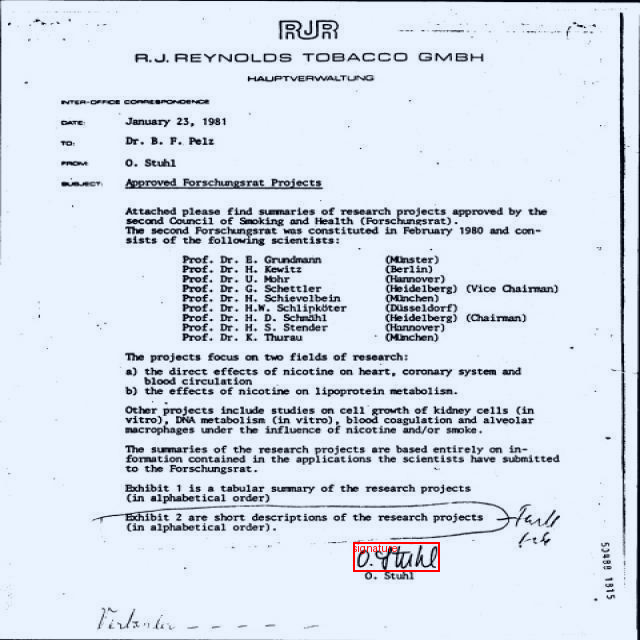

In [8]:
from utils.visualizer import visualize_item

visualize_item(test_dataset[0])

Fine-tuning the model

In [10]:
from utils.model import YolosForSignatureDetection

pl_model = YolosForSignatureDetection(lr=2.5e-5, weight_decay=1e-4, model=model)

outputs = pl_model(pixel_values=batch["pixel_values"].to(model.device))
outputs.logits.shape

c:\Users\defra\AppData\Local\pypoetry\Cache\virtualenvs\signature-detection-Nok2ZUKi-py3.12\Lib\site-packages\pytorch_lightning\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


torch.Size([1, 100, 2])

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [ ]:
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# Create an EarlyStopping callback
early_stopping = EarlyStopping(monitor="validation_loss", mode="min", patience=5, verbose=True)

# Create a ModelCheckpoint callback
validation_callback = ModelCheckpoint(monitor="validation_loss", mode="min", save_top_k=1, filename="best-val-checkpoint", verbose=True)
training_callback = ModelCheckpoint(monitor="training_loss", mode="min", save_top_k=1, filename="best-train-checkpoint", verbose=True)

callbacks = [early_stopping, validation_callback, training_callback]

In [ ]:
from pytorch_lightning import Trainer

# creating trainer 
# accumulate_grad_batches = 4 allows the model to accumulate gradients over 4 batches before performing a backward pass, effectively simulating a larger batch size.
# gradient_clip_val is set to 0.1 to prevent exploding gradients, which can occur during training, especially with larger models or datasets.
trainer = Trainer(max_epochs=100, gradient_clip_val=0.1, accumulate_grad_batches=4*8, callbacks=callbacks, accelerator="cpu")

# Fit the model using the trainer
trainer.fit(pl_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

Evaluating model

In [12]:
import torch

checkpoint = torch.load("lightning_logs/version_small/best-val-checkpoint.ckpt", weights_only=False)
pl_model = YolosForSignatureDetection(lr=1e-4, weight_decay=1e-4, model=model)
pl_model.load_state_dict(checkpoint["state_dict"])
pl_model.model.to("cpu")

c:\Users\defra\AppData\Local\pypoetry\Cache\virtualenvs\signature-detection-Nok2ZUKi-py3.12\Lib\site-packages\pytorch_lightning\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


YolosForObjectDetection(
  (vit): YolosModel(
    (embeddings): YolosEmbeddings(
      (patch_embeddings): YolosPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
      (interpolation): InterpolateInitialPositionEmbeddings()
    )
    (encoder): YolosEncoder(
      (layer): ModuleList(
        (0-11): 12 x YolosLayer(
          (attention): YolosAttention(
            (attention): YolosSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): YolosSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): YolosIntermediate(
            (dense

Evaluating model

In [13]:
import json

from utils.evaluate import evaluate_model

# model evaluation
evaluation = evaluate_model(test_dataset.coco, test_dataloader, pl_model.model, image_processor)

# Save the evaluation results to a JSON file
with open("evaluation-yolos-base.json", "w", encoding="utf-8") as f:
    json.dump(evaluation, f, indent=4)

Running evaluation...


  0%|          | 0/419 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.44s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.476
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.864
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.482
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.111
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.467
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.558
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.482
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.618
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.678
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.670
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

Saving fine-tuned model to the Hub

In [ ]:
hf_model_name = CKPT_PATH.split("/")[-1] + "-signature-detection"
print("model saved at:", hf_model_name)

# saving model locally
pl_model.model.save_pretrained(hf_model_name)
image_processor.save_pretrained(hf_model_name)

# saving model to the Hub
pl_model.model.push_to_hub(hf_model_name)
image_processor.push_to_hub(hf_model_name)


# Inference example

In [18]:
from transformers import pipeline

yolos = pipeline(
    task="object-detection",
    model="mdefrance/yolos-base-signature-detection",
    device_map="auto",
)


config.json:   0%|          | 0.00/822 [00:00<?, ?B/s]

c:\Users\defra\AppData\Local\pypoetry\Cache\virtualenvs\signature-detection-Nok2ZUKi-py3.12\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\defra\.cache\huggingface\hub\models--mdefrance--yolos-base-signature-detection. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/511M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
from utils.visualizer import convert_tensor_to_pil_image

# applying inference on images of the test set
predictions = yolos([convert_tensor_to_pil_image(item[0]) for item in test_dataset], batch_size=4)

Visualizing prediction and input

In [ ]:
from utils.visualizer import visualize_prediction

item_idx = 15
visualize_prediction(test_dataset[item_idx], predictions[item_idx])